<a href="https://colab.research.google.com/github/naufalkr/erp-transaction-anomaly-generative-ai/blob/main/ERP_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset and Dependencies

In [ ]:
!pip install jupyterthemes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()
import seaborn as sns
import matplotlib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/naufalkr/XAI-erp-transaction-anomaly/main/financial_anomaly_data.csv')
df.shape

(217441, 7)

In [ ]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [ ]:
df.tail()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
217436,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217440,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960


In [ ]:
df.dtypes

,0
Timestamp,object
TransactionID,object
AccountID,object
Amount,float64
Merchant,object
TransactionType,object
Location,object


In [ ]:
df.describe()

,Amount
count,216960.000000
mean,50090.025108
std,29097.905016
min,10.510000
25%,25061.242500
50%,50183.980000
75%,75080.460000
max,978942.260000


# Handling Missing Value


In [ ]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481


In [ ]:
value_counts = {column: df[column].value_counts() for column in df.columns}
value_counts

{'Timestamp': Timestamp
 01-01-2023 08:00    1
 11-04-2023 18:57    1
 11-04-2023 18:33    1
 11-04-2023 18:34    1
 11-04-2023 18:35    1
                    ..
 20-02-2023 13:23    1
 20-02-2023 13:24    1
 20-02-2023 13:25    1
 20-02-2023 13:26    1
 31-05-2023 23:59    1
 Name: count, Length: 216960, dtype: int64,
 'TransactionID': TransactionID
 TXN838     139
 TXN1768    139
 TXN1658    139
 TXN1389    138
 TXN340     137
           ... 
 TXN60       79
 TXN891      78
 TXN605      78
 TXN201      73
 TXN799      70
 Name: count, Length: 1999, dtype: int64,
 'AccountID': AccountID
 ACC15    14701
 ACC5     14630
 ACC7     14581
 ACC2     14553
 ACC9     14527
 ACC14    14458
 ACC4     14456
 ACC11    14446
 ACC12    14421
 ACC13    14421
 ACC8     14402
 ACC1     14365
 ACC10    14362
 ACC6     14352
 ACC3     14285
 Name: count, dtype: int64,
 'Amount': Amount
 18010.00    3
 34588.69    3
 74109.74    3
 86099.64    3
 7309.50     3
            ..
 56652.57    1
 36336.36    1

In [ ]:
# Convert the 'Timestamp' column to datetime format if it isn't already
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Extract the date (year-month-day) without the time
df['Date'] = df['Timestamp'].dt.date

# Calculate value counts for each unique date
date_counts = df['Date'].value_counts().sort_index()

date_counts

,count
Date,
2023-01-01,960
2023-01-02,1440
2023-01-03,1440
2023-01-04,1440
2023-01-05,1440
...,...
2023-05-27,1440
2023-05-28,1440
2023-05-29,1440


In [ ]:
df.isna().sum()

,0
Timestamp,481
TransactionID,481
AccountID,481
Amount,481
Merchant,481
TransactionType,481
Location,481
Date,481


In [ ]:
transaction_counts = df['TransactionType'].value_counts()

# Display the counts
print(transaction_counts)

TransactionType
Transfer      72793
Purchase      72235
Withdrawal    71932
Name: count, dtype: int64


In [ ]:
df = df.dropna()
df.isna().sum()

,0
Timestamp,0
TransactionID,0
AccountID,0
Amount,0
Merchant,0
TransactionType,0
Location,0
Date,0


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')
df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01-01
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01-01
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01-01
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01-01
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01-01
...,...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco,2023-05-31
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London,2023-05-31
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London,2023-05-31
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York,2023-05-31


In [ ]:
df.count()

,0
Timestamp,216960
TransactionID,216960
AccountID,216960
Amount,216960
Merchant,216960
TransactionType,216960
Location,216960
Date,216960


In [ ]:
df.iloc[9]

,9
Timestamp,2023-01-01 08:09:00
TransactionID,TXN1479
AccountID,ACC12
Amount,49522.74
Merchant,MerchantC
TransactionType,Withdrawal
Location,New York
Date,2023-01-01


# Exploratory Data Analysis (EDA)

<Axes: xlabel='Timestamp'>

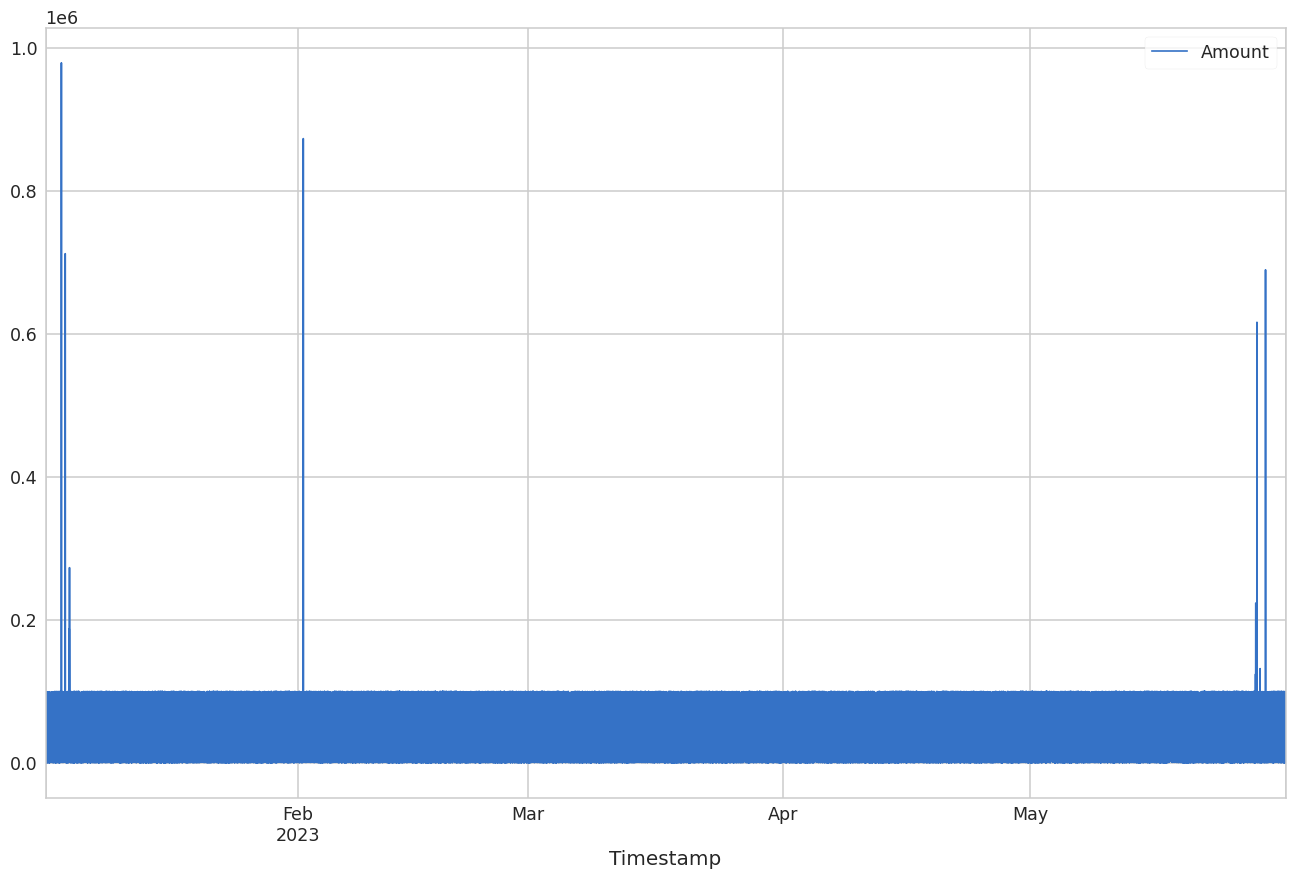

In [ ]:
# Transaction based on timestamp
df.set_index('Timestamp').plot(figsize=(16, 10))

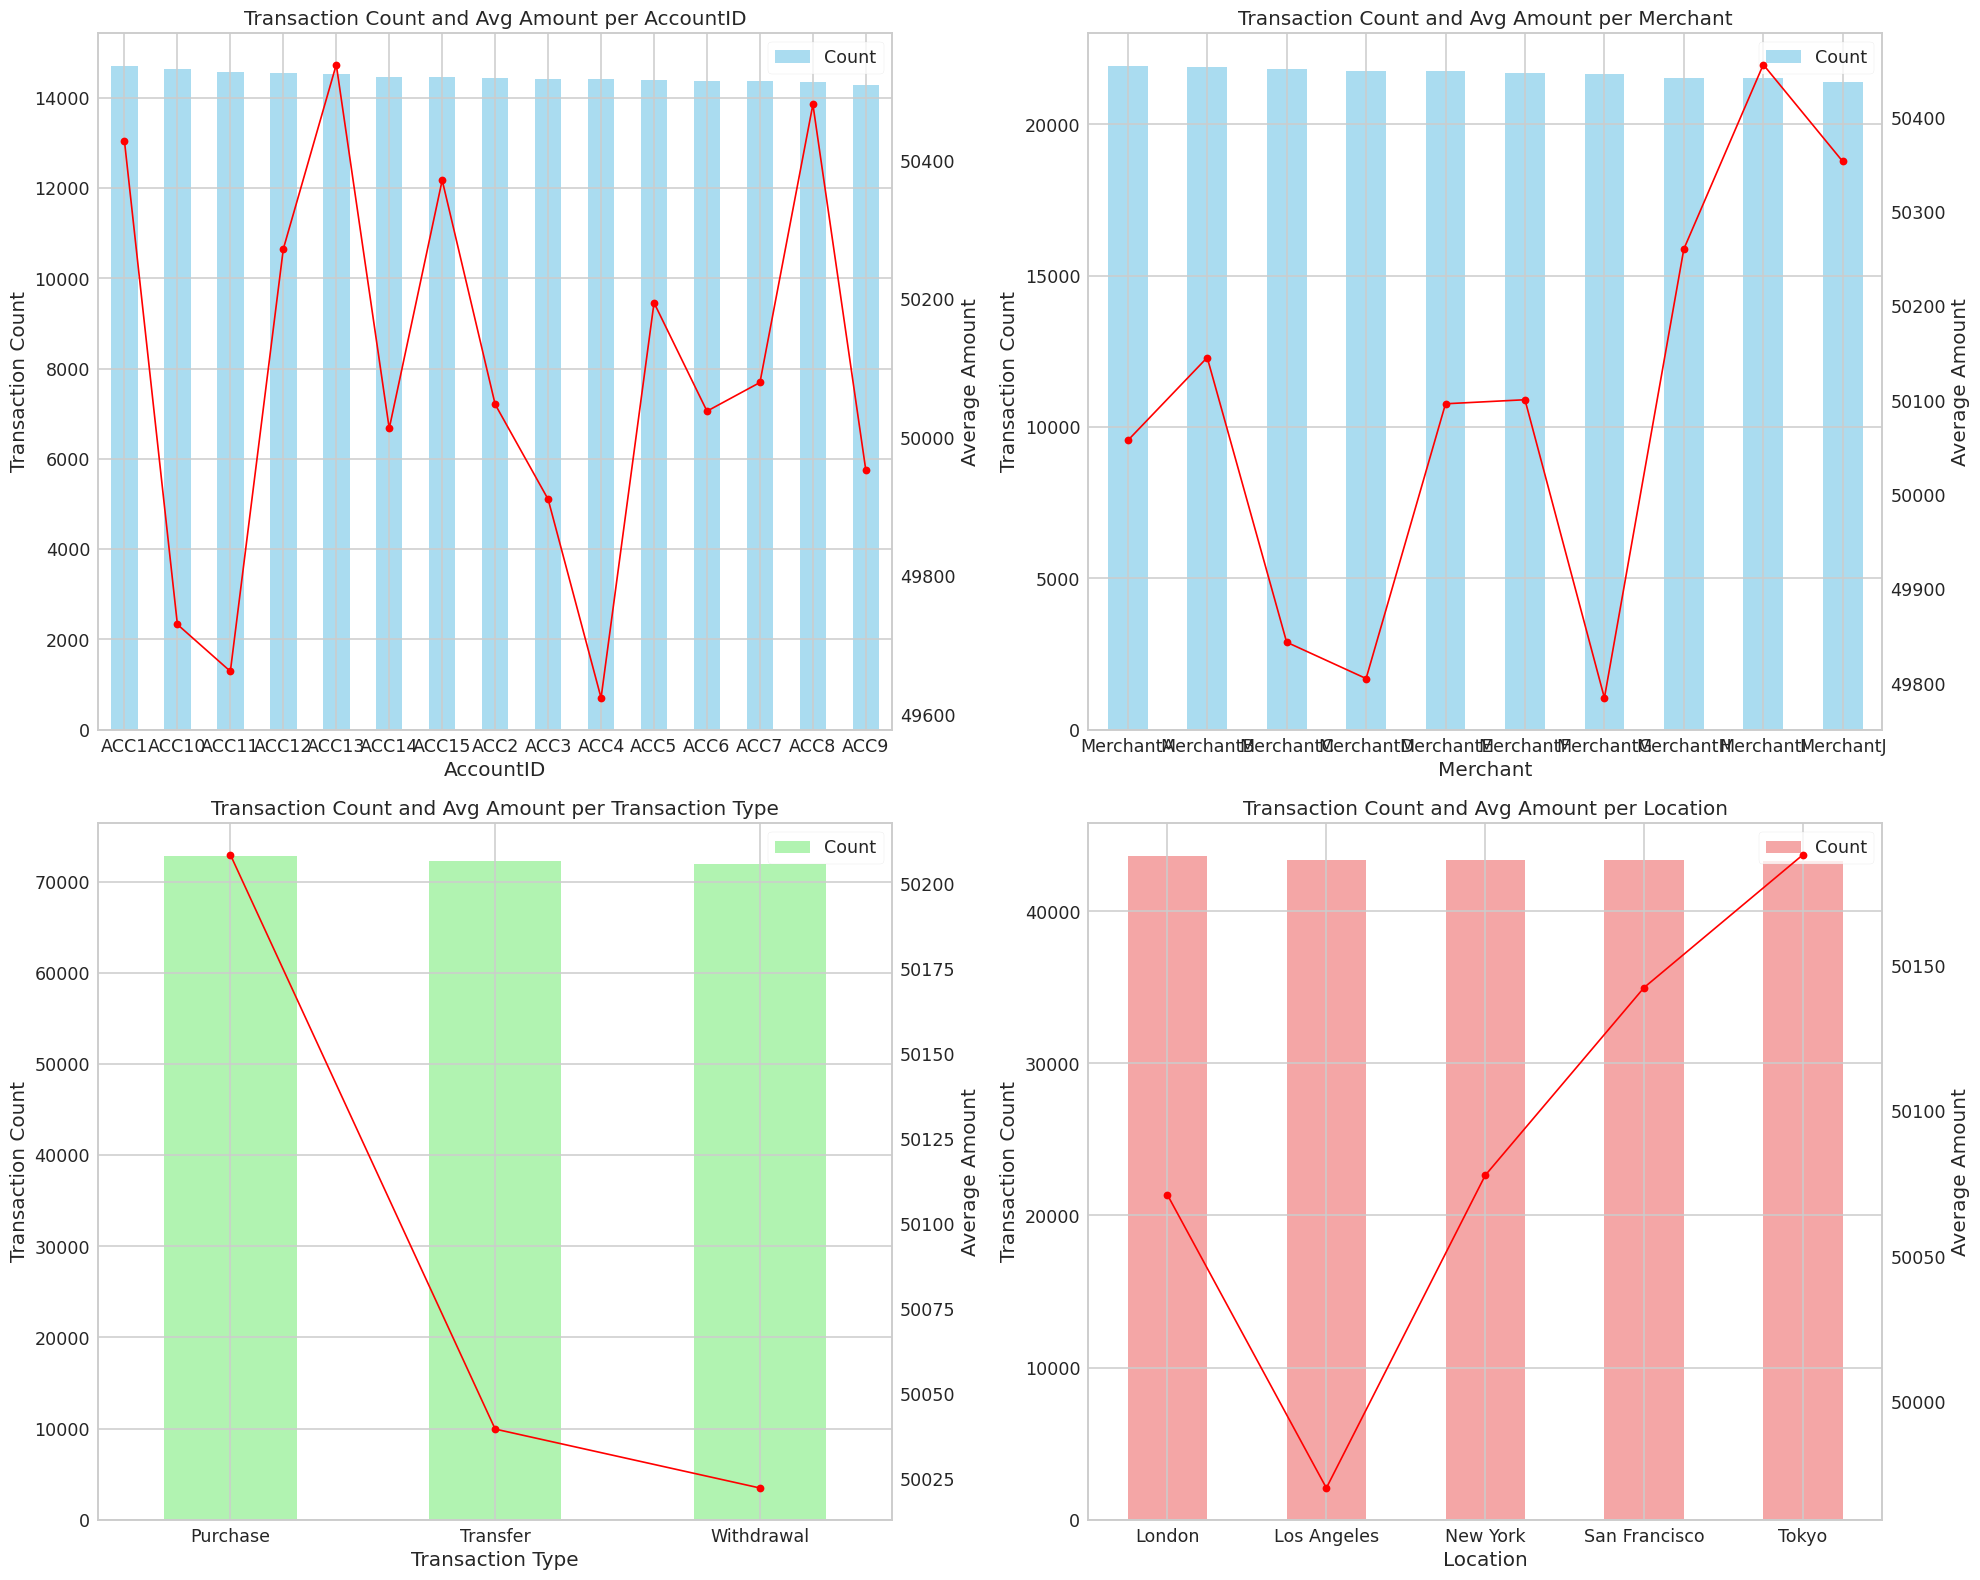

In [ ]:
import matplotlib.pyplot as plt

# Set up a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 2: AccountID distribution - Count and Average Amount
AccountID_counts = df['AccountID'].value_counts()
AccountID_avg_amount = df.groupby('AccountID')['Amount'].mean()
AccountID_counts.plot(kind='bar', ax=axes[0, 0], color='skyblue', alpha=0.7, label='Count')
AccountID_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 0], color='red', label='Avg Amount')
axes[0, 0].set_title("Transaction Count and Avg Amount per AccountID")
axes[0, 0].set_xlabel("AccountID")
axes[0, 0].set_ylabel("Transaction Count")
axes[0, 0].right_ax.set_ylabel("Average Amount")
axes[0, 0].legend()

# Plot 2: Merchant distribution - Count and Average Amount
merchant_counts = df['Merchant'].value_counts()
merchant_avg_amount = df.groupby('Merchant')['Amount'].mean()
merchant_counts.plot(kind='bar', ax=axes[0, 1], color='skyblue', alpha=0.7, label='Count')
merchant_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[0, 1], color='red', label='Avg Amount')
axes[0, 1].set_title("Transaction Count and Avg Amount per Merchant")
axes[0, 1].set_xlabel("Merchant")
axes[0, 1].set_ylabel("Transaction Count")
axes[0, 1].right_ax.set_ylabel("Average Amount")
axes[0, 1].legend()

# Plot 3: Transaction Type distribution - Count and Average Amount
type_counts = df['TransactionType'].value_counts()
type_avg_amount = df.groupby('TransactionType')['Amount'].mean()
type_counts.plot(kind='bar', ax=axes[1, 0], color='lightgreen', alpha=0.7, label='Count')
type_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 0], color='red', label='Avg Amount')
axes[1, 0].set_title("Transaction Count and Avg Amount per Transaction Type")
axes[1, 0].set_xlabel("Transaction Type")
axes[1, 0].set_ylabel("Transaction Count")
axes[1, 0].right_ax.set_ylabel("Average Amount")
axes[1, 0].legend()

# Plot 4: Location distribution - Count and Average Amount
location_counts = df['Location'].value_counts()
location_avg_amount = df.groupby('Location')['Amount'].mean()
location_counts.plot(kind='bar', ax=axes[1, 1], color='lightcoral', alpha=0.7, label='Count')
location_avg_amount.plot(kind='line', marker='o', secondary_y=True, ax=axes[1, 1], color='red', label='Avg Amount')
axes[1, 1].set_title("Transaction Count and Avg Amount per Location")
axes[1, 1].set_xlabel("Location")
axes[1, 1].set_ylabel("Transaction Count")
axes[1, 1].right_ax.set_ylabel("Average Amount")
axes[1, 1].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# Multivariate Anomaly Detection

In this example, we will perform anomaly detection on multiple features of transaction data, such as Amount, TransactionType, and AccountID, using an Isolation Forest model from the pyod library.

The dataset is divided by location because each location may have different spending patterns or transaction amounts. This differentiation allows us to account for location-specific variations in spending behavior, which can affect what is considered "normal" or "anomalous" in each region.

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=7e884bec0d1df21ac87dc2038a88858c316103f410ecf64cb5c3ed016236b94b
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## Extract Subset Data for Outlier Detection

In [ ]:
cols = ['Amount', 'TransactionType', 'Location', 'AccountID']
subset_df = df[cols]
subset_df.head()

,Amount,TransactionType,Location,AccountID
0,95071.92,Purchase,Tokyo,ACC4
1,15607.89,Purchase,London,ACC10
2,65092.34,Withdrawal,London,ACC8
3,87.87,Purchase,London,ACC6
4,716.56,Purchase,Los Angeles,ACC6


In [ ]:
# One hot encoding
subset_df = pd.get_dummies(subset_df, columns=['TransactionType', 'AccountID'], drop_first=False)
subset_df.head()

,Amount,Location,TransactionType_Purchase,TransactionType_Transfer,TransactionType_Withdrawal,AccountID_ACC1,AccountID_ACC10,AccountID_ACC11,AccountID_ACC12,AccountID_ACC13,AccountID_ACC14,AccountID_ACC15,AccountID_ACC2,AccountID_ACC3,AccountID_ACC4,AccountID_ACC5,AccountID_ACC6,AccountID_ACC7,AccountID_ACC8,AccountID_ACC9
0,95071.92,Tokyo,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,15607.89,London,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,65092.34,London,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,87.87,London,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,716.56,Los Angeles,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Columns to scale (Amount, TransactionType, AccountID)
cols_to_scale = ['Amount'] + [col for col in subset_df.columns if col.startswith('TransactionType_') or col.startswith('AccountID_')]
cols_to_scale

['Amount',
 'TransactionType_Purchase',
 'TransactionType_Transfer',
 'TransactionType_Withdrawal',
 'AccountID_ACC1',
 'AccountID_ACC10',
 'AccountID_ACC11',
 'AccountID_ACC12',
 'AccountID_ACC13',
 'AccountID_ACC14',
 'AccountID_ACC15',
 'AccountID_ACC2',
 'AccountID_ACC3',
 'AccountID_ACC4',
 'AccountID_ACC5',
 'AccountID_ACC6',
 'AccountID_ACC7',
 'AccountID_ACC8',
 'AccountID_ACC9']

## Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(0, 1))
# subset_df[cols] = mms.fit_transform(subset_df)
# subset_df.head()

## Multivariate Anomaly Detection with Isolation Forest

The Isolation Forest (IForest) model is a popular anomaly detection algorithm designed to identify anomalies by isolating data points rather than clustering them. It works by randomly selecting features and values to partition the data and measuring the number of splits required to isolate a data point. Anomalies, which are rare and different from the majority, typically require fewer splits to be isolated than normal points.

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import numpy as np

# Fungsi untuk membuat Autoencoder
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoding_dim = 32  # Menentukan dimensi encoding

    # Encoding layer
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    # Decoding layer
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mean_squared_error')

    return autoencoder

### Initialize and Train Model


In [ ]:
outliers_per_location = {}

for location in df['Location'].unique():
    # Subset by location
    location_df = subset_df[df['Location'] == location].drop(columns=['Location'])
    location_df[cols_to_scale] = mms.fit_transform(location_df[cols_to_scale])

    rule_based_outliers = pd.Series(0, index=location_df.index)

    account_id_cols = [col for col in location_df.columns if col.startswith('AccountID_')]

    # Layer 1: Rule-Based Detection per AccountID dan TransactionType
    for account_id_col in account_id_cols:
        account_df = location_df[location_df[account_id_col] == 1]

        for transaction_type in ['TransactionType_Purchase',
                                'TransactionType_Transfer',
                                'TransactionType_Withdrawal']:
            # Filter by TransactionType
            transaction_df = account_df[account_df[transaction_type] == 1]

            if not transaction_df.empty:  # Pastikan subset tidak kosong
                # Amount thresholds
                high_threshold = transaction_df['Amount'].quantile(0.99)
                low_threshold = transaction_df['Amount'].quantile(0.01)

                # Detect outliers based on thresholds
                transaction_outliers = (
                    (transaction_df['Amount'] > high_threshold) |
                    (transaction_df['Amount'] < low_threshold)
                ).astype(int)

                # Update rule-based outliers
                rule_based_outliers.loc[transaction_df.index] = transaction_outliers

    # --- Layer 2: Isolation Forest ---
    iforest_model = IsolationForest(contamination=0.01, random_state=42)
    iforest_model.fit(location_df)
    iforest_outliers = (iforest_model.predict(location_df) == -1).astype(int)

    # --- Layer 3: Autoencoder for Anomaly Detection ---
    input_dim = location_df.shape[1]  # Dimensi input sesuai dengan jumlah fitur
    autoencoder = create_autoencoder(input_dim)
    autoencoder.fit(location_df, location_df, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=0)

    reconstruction = autoencoder.predict(location_df)
    reconstruction_error = np.mean(np.square(location_df - reconstruction), axis=1)

    threshold_autoencoder = np.percentile(reconstruction_error, 99)

    autoencoder_outliers = (reconstruction_error > threshold_autoencoder).astype(int)

    # --- Layer 4: Ensemble Method (Combine rule-based, Isolation Forest, and Autoencoder predictions) ---
    ensemble_outliers = (0.33 * rule_based_outliers + 0.33 * iforest_outliers + 0.34 * autoencoder_outliers) >= 0.5
    location_outliers_df = location_df[ensemble_outliers]
    total_outliers_location = len(location_outliers_df)
    outliers_per_location[location] = total_outliers_location

    location_outliers_df['Location'] = location

    # Save outliers per location
    outlier_var_name = f"outliers_{location}".replace(" ", "_")
    outlier_var_name_model_shape = f"outliers_{location}_model_shape".replace(" ", "_")
    globals()[outlier_var_name] = df.loc[location_outliers_df.index.tolist()][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]
    globals()[outlier_var_name_model_shape] = location_outliers_df

    # print(f"Outlier Transactions for {location}:")
    # print(globals()[outlier_var_name])

1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1355/1355 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1363/1363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1356/1356 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# # Different weight configurations test (New York)
# configs = [
#     {"rule_weight": 0.4, "iforest_weight": 0.6, "threshold": 0.5},
#     {"rule_weight": 0.6, "iforest_weight": 0.4, "threshold": 0.5},
#     {"rule_weight": 0.5, "iforest_weight": 0.5, "threshold": 0.5},
#     {"rule_weight": 0.4, "iforest_weight": 0.6, "threshold": 0.4},
#     {"rule_weight": 0.5, "iforest_weight": 0.5, "threshold": 0.6},
# ]

# results = []

# for config in configs:
#     ensemble_outliers = (
#         config["rule_weight"] * rule_based_outliers +
#         config["iforest_weight"] * iforest_outliers
#     ) >= config["threshold"]

#     total_outliers = ensemble_outliers.sum()
#     config_result = {
#         "rule_weight": config["rule_weight"],
#         "iforest_weight": config["iforest_weight"],
#         "threshold": config["threshold"],
#         "total_outliers_ny": total_outliers
#     }
#     results.append(config_result)

# pd.DataFrame(results)


## Detected outliers

In [ ]:
# outliers total for each location
print("Total Outliers per Location:")
outliers_location_df = pd.DataFrame(list(outliers_per_location.items()), columns=['Location', 'Outlier Count'])
print(outliers_location_df)

Total Outliers per Location:
        Location  Outlier Count
0          Tokyo            319
1         London            323
2    Los Angeles            222
3  San Francisco            262
4       New York            289


In [ ]:
outliers_Tokyo.head()

,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
612,TXN632,ACC7,446.28,MerchantG,Purchase,Tokyo
1526,TXN1975,ACC7,596.41,MerchantH,Purchase,Tokyo
2437,TXN875,ACC8,1005.87,MerchantJ,Withdrawal,Tokyo
3448,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo
3453,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo


In [ ]:
outliers_Los_Angeles.head()

,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
1613,TXN264,ACC4,719.58,MerchantD,Withdrawal,Los Angeles
4194,TXN667,ACC3,272990.11,MerchantE,Transfer,Los Angeles
9366,TXN573,ACC9,360.82,MerchantC,Transfer,Los Angeles
9516,TXN917,ACC11,1026.77,MerchantG,Withdrawal,Los Angeles
10067,TXN1619,ACC11,667.50,MerchantC,Withdrawal,Los Angeles


In [ ]:
# outliers total
total_outliers_all_locations = sum(outliers_per_location.values())
print(f"\nTotal Outliers across all locations: {total_outliers_all_locations}")


Total Outliers across all locations: 1415


In [ ]:
# Added outliers column to df
df['Outlier'] = 0

outlier_indices = (
    outliers_Tokyo_model_shape.index
    .union(outliers_London_model_shape.index)
    .union(outliers_New_York_model_shape.index)
    .union(outliers_San_Francisco_model_shape.index)
    .union(outliers_Los_Angeles_model_shape.index)
)
df.loc[outlier_indices, 'Outlier'] = 1
df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date,Outlier
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01-01,0
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01-01,0
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01-01,0
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01-01,0
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01-01,0
...,...,...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco,2023-05-31,0
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London,2023-05-31,0
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London,2023-05-31,0
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York,2023-05-31,0


In [ ]:
# df Outlier = 1
outliers_df = df[df['Outlier'] == 1]
outliers_df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date,Outlier
142,2023-01-01 10:22:00,TXN831,ACC13,269.48,MerchantD,Purchase,New York,2023-01-01,1
272,2023-01-01 12:32:00,TXN1055,ACC7,524.47,MerchantE,Withdrawal,San Francisco,2023-01-01,1
534,2023-01-01 16:54:00,TXN998,ACC1,776.33,MerchantH,Transfer,London,2023-01-01,1
590,2023-01-01 17:50:00,TXN1512,ACC7,241.73,MerchantC,Purchase,London,2023-01-01,1
612,2023-01-01 18:12:00,TXN632,ACC7,446.28,MerchantG,Purchase,Tokyo,2023-01-01,1
...,...,...,...,...,...,...,...,...,...
216667,2023-05-31 19:07:00,TXN731,ACC2,620.87,MerchantI,Purchase,San Francisco,2023-05-31,1
216719,2023-05-31 19:59:00,TXN1532,ACC7,900.53,MerchantH,Purchase,Los Angeles,2023-05-31,1
216747,2023-05-31 20:27:00,TXN207,ACC5,1564.36,MerchantI,Withdrawal,London,2023-05-31,1
216809,2023-05-31 21:29:00,TXN1482,ACC13,39.46,MerchantH,Purchase,New York,2023-05-31,1


In [ ]:
# df Outlier = 1
non_outliers_df = df[df['Outlier'] == 0]
non_outliers_df

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date,Outlier
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01-01,0
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01-01,0
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01-01,0
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01-01,0
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01-01,0
...,...,...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco,2023-05-31,0
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London,2023-05-31,0
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London,2023-05-31,0
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York,2023-05-31,0


In [ ]:
outliers_df.groupby('AccountID').size()

,0
AccountID,
ACC1,50
ACC10,64
ACC11,72
ACC12,98
ACC13,66
ACC14,59
ACC15,63
ACC2,132
ACC3,86


# Generative AI

In [ ]:
# Count transaction per month
df_gen = df.copy()
df_gen['Date'] = pd.to_datetime(df_gen['Date'])
df_gen['Year_Month'] = df_gen['Date'].dt.to_period('M')
monthly_count = df_gen.groupby('Year_Month').size()

df_gen.drop(columns=['Date'], inplace=True)
cols = [col for col in df_gen.columns if col != 'Outlier']
df_gen = df_gen[cols + ['Outlier']]

print(monthly_count)

Year_Month
2023-01    44160
2023-02    40320
2023-03    44640
2023-04    43200
2023-05    44640
Freq: M, dtype: int64


In [ ]:
df_gen

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Year_Month,Outlier
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01,0
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01,0
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01,0
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01,0
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01,0
...,...,...,...,...,...,...,...,...,...
216955,2023-05-31 23:55:00,TXN1286,ACC6,62536.88,MerchantA,Withdrawal,San Francisco,2023-05,0
216956,2023-05-31 23:56:00,TXN1015,ACC5,68629.69,MerchantG,Transfer,London,2023-05,0
216957,2023-05-31 23:57:00,TXN1979,ACC15,8203.57,MerchantF,Purchase,London,2023-05,0
216958,2023-05-31 23:58:00,TXN1845,ACC14,77800.36,MerchantF,Purchase,New York,2023-05,0


In [ ]:
cols = ['Amount', 'TransactionType', 'Location', 'AccountID', 'Outlier']
subset_df = df_gen[cols]
subset_df.head()

,Amount,TransactionType,Location,AccountID,Outlier
0,95071.92,Purchase,Tokyo,ACC4,0
1,15607.89,Purchase,London,ACC10,0
2,65092.34,Withdrawal,London,ACC8,0
3,87.87,Purchase,London,ACC6,0
4,716.56,Purchase,Los Angeles,ACC6,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
# # One-hot encoding untuk kolom kategori
# subset_df = pd.get_dummies(subset_df, columns=['TransactionType', 'Location', 'AccountID'], drop_first=True)

# Label encoder
label_encoders = {}
for col in ['TransactionType', 'Location', 'AccountID']:
    le = LabelEncoder()
    subset_df[col] = le.fit_transform(subset_df[col])
    label_encoders[col] = le


In [ ]:
mms = MinMaxScaler(feature_range=(0, 1))
subset_df['Amount'] = mms.fit_transform(subset_df[['Amount']])
cols_to_scale = ['Amount'] + [col for col in subset_df.columns if col.startswith('TransactionType_') or col.startswith('Location_') or col.startswith('AccountID_')]

In [ ]:
subset_df

,Amount,TransactionType,Location,AccountID,Outlier
0,0.097107,0,4,9,0
1,0.015933,0,0,1,0
2,0.066482,2,0,13,0
3,0.000079,0,0,11,0
4,0.000721,0,1,11,0
...,...,...,...,...,...
216955,0.063872,2,3,11,0
216956,0.070096,1,0,10,0
216957,0.008369,0,0,6,0
216958,0.079464,0,2,5,0


Outlier
0    215545
1      1415
Name: count, dtype: int64


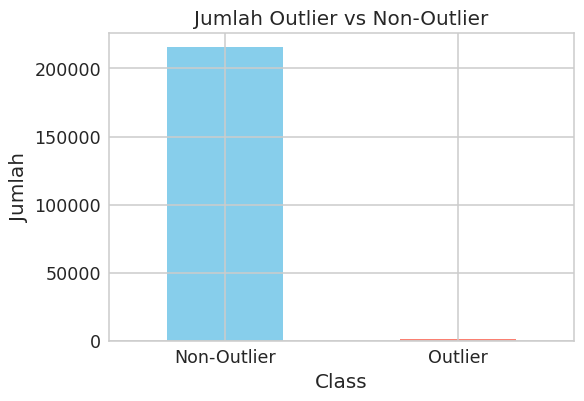

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Misalnya, df adalah dataset yang sudah dimodifikasi
# Hitung jumlah outlier dan non-outlier
outlier_counts = subset_df['Outlier'].value_counts()

# Tampilkan statistik jumlah outlier dan non-outlier
print(outlier_counts)

# Visualisasikan dalam bentuk bar plot
plt.figure(figsize=(6, 4))
outlier_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Jumlah Outlier vs Non-Outlier')
plt.xlabel('Class')
plt.ylabel('Jumlah')
plt.xticks(ticks=[0, 1], labels=['Non-Outlier', 'Outlier'], rotation=0)
plt.show()

## Training and Testing

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

# Inisialisasi model dan parameter
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# k-Fold Cross-Validation
k = 5  # Jumlah fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Menyimpan hasil evaluasi untuk setiap fold
models = []
fold_results = []

X = subset_df.drop(columns=['Outlier'])
y = subset_df['Outlier']

In [ ]:
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}/{k}")

    # Data training dan testing untuk fold ini
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train model
    xgb_model.fit(X_train, y_train)

    # Simpan model untuk digunakan nanti
    models.append(xgb_model)

    # Predict
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    false_positive_rate = conf_matrix[0][1] / (conf_matrix[0][1] + conf_matrix[0][0])
    auc_score = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_test, y_pred)

    # Simpan hasil evaluasi untuk fold ini
    fold_results.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'false_positive_rate': false_positive_rate,
        'roc_auc': auc_score,
        'classification_report': class_report
    })

    # Tampilkan hasil evaluasi untuk fold ini
    print(f"Accuracy: {accuracy:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(class_report)

    print(f"Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}")

Fold 1/5
Accuracy: 0.9985
False Positive Rate: 0.0005
AUC Score: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43114
           1       0.91      0.85      0.88       278

    accuracy                           1.00     43392
   macro avg       0.96      0.93      0.94     43392
weighted avg       1.00      1.00      1.00     43392

Accuracy: 0.9985, AUC: 0.9995
Fold 2/5
Accuracy: 0.9984
False Positive Rate: 0.0006
AUC Score: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     43127
           1       0.90      0.84      0.87       265

    accuracy                           1.00     43392
   macro avg       0.95      0.92      0.93     43392
weighted avg       1.00      1.00      1.00     43392

Accuracy: 0.9984, AUC: 0.9993
Fold 3/5
Accuracy: 0.9985
False Positive Rate: 0.0006
AUC Score: 0.9991

Classification Report

In [ ]:
# Rata-rata hasil evaluasi
avg_accuracy = sum([res['accuracy'] for res in fold_results]) / k
avg_false_positive_rate = sum([res['false_positive_rate'] for res in fold_results]) / k
avg_auc = sum([res['roc_auc'] for res in fold_results]) / k

print("\nOverall Results:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average False Positive Rate: {avg_false_positive_rate:.4f}")
print(f"Average AUC Score: {avg_auc:.4f}")


Overall Results:
Average Accuracy: 0.9984
Average False Positive Rate: 0.0006
Average AUC Score: 0.9994


## SHAP

In [ ]:
!pip install shap

In [ ]:
y_test

,Outlier
5,0
10,0
15,0
16,0
18,0
...,...
216929,0
216935,0
216936,0
216948,0


In [ ]:
X_test

,Amount,TransactionType,Location,AccountID
5,0.014248,1,0,6
10,0.067671,2,3,7
15,0.100802,0,0,14
16,0.001438,0,1,13
18,0.088159,2,2,3
...,...,...,...,...
216929,0.028204,2,4,11
216935,0.048084,0,4,1
216936,0.061024,2,4,5
216948,0.052200,2,3,8


In [ ]:
import shap

# Calculate SHAP values for each model
shap_values_list = []

for fold, model in enumerate(models):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)  # SHAP values for test set in this fold
    shap_values_list.append(shap_values)

# Aggregate SHAP values (mean across folds)
shap_values_mean = np.mean([shap_values.values for shap_values in shap_values_list], axis=0)

# # Dapatkan nilai SHAP per fitur
# shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
# shap_values_df['total_contribution'] = shap_values_df.sum(axis=1)

# # VISUALISASI NON OUTLIER (Index 0)
# shap.initjs()
# shap.plots.force(shap_values_mean[0])

In [ ]:
shap_values_mean

array([[-7.4171157 , -0.87522155, -0.94601834, -0.8262116 ],
       [-7.487582  ,  0.04052773, -0.53342897,  0.34364152],
       [-2.0909255 ,  0.13669291, -0.40670258, -0.64875853],
       ...,
       [-6.6870446 ,  0.52881575,  0.29790533, -1.8539715 ],
       [-6.6880555 , -0.27970424, -0.5201828 ,  0.04240995],
       [-8.055361  , -0.3109539 , -1.1815096 , -1.3109574 ]],
      dtype=float32)

In [ ]:
# Buat DataFrame dari rata-rata SHAP values
shap_values_mean_df = pd.DataFrame(
    shap_values_mean,
    columns=X_test.columns  # Nama fitur
)
shap_values_mean_df['total_contribution'] = shap_values_mean_df.sum(axis=1)  # Total kontribusi per baris

# Tampilkan DataFrame
shap_values_mean_df

,Amount,TransactionType,Location,AccountID,total_contribution
0,-7.417116,-0.875222,-0.946018,-0.826212,-10.064568
1,-7.487582,0.040528,-0.533429,0.343642,-7.636842
2,-2.090925,0.136693,-0.406703,-0.648759,-3.009694
3,2.712854,-1.072791,-0.644018,-1.761534,-0.765489
4,-6.857667,-0.861668,-0.142550,-1.559942,-9.421826
...,...,...,...,...,...
43387,-7.063837,0.427466,0.714339,-0.816306,-6.738338
43388,-6.991656,-0.834122,-0.043679,-0.975931,-8.845388
43389,-6.687045,0.528816,0.297905,-1.853971,-7.714295
43390,-6.688056,-0.279704,-0.520183,0.042410,-7.445532


In [ ]:
# Filter shap_values_mean_df untuk baris dengan total_contribution positif
positive_contributions_df = shap_values_mean_df[shap_values_mean_df['total_contribution'] > 0]
positive_contributions_df

,Amount,TransactionType,Location,AccountID,total_contribution
40,0.496230,0.485699,0.432384,1.954502,3.368815
53,6.608785,-1.161051,-0.782453,-2.205133,2.460146
58,6.550359,-0.940431,-0.767857,-0.768515,4.073556
107,6.327239,-0.117224,1.222854,-0.456542,6.976326
216,4.746337,0.247838,-0.882127,-0.231845,3.880204
...,...,...,...,...,...
43313,-0.371691,1.132138,0.866409,-1.235138,0.391719
43316,0.116487,0.662092,-0.695059,1.855220,1.938739
43322,4.828414,-0.272158,-0.492586,-0.277069,3.786601
43345,6.072022,0.282563,0.438477,0.354827,7.147890


In [ ]:
# Outlier
shap.initjs()
sample_index = 43316  # Ganti dengan indeks yang ingin Anda visualisasikan

print(f"\nVisualizing Force Plot for a Sample Row (Index {sample_index}):")
shap.plots.force(
    base_value=explainer.expected_value,  # Base value untuk model
    shap_values=shap_values_mean[sample_index],  # SHAP values untuk baris tertentu
    features=X.iloc[sample_index],  # Fitur untuk baris tertentu
    feature_names=X.columns  # Nama fitur
)


Visualizing Force Plot for a Sample Row (Index 43316):


In [ ]:
# Non Outlier
shap.initjs()
sample_index = 43388  # Ganti dengan indeks yang ingin Anda visualisasikan

print(f"\nVisualizing Force Plot for a Sample Row (Index {sample_index}):")
shap.plots.force(
    base_value=explainer.expected_value,  # Base value untuk model
    shap_values=shap_values_mean[sample_index],  # SHAP values untuk baris tertentu
    features=X.iloc[sample_index],  # Fitur untuk baris tertentu
    feature_names=X.columns  # Nama fitur
)


Visualizing Force Plot for a Sample Row (Index 43388):


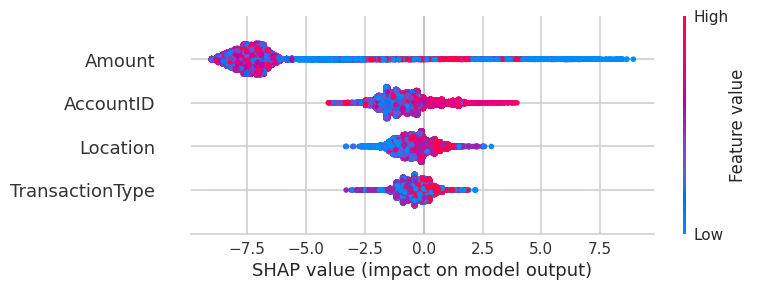

In [ ]:
# Create summary plot using aggregated SHAP values
shap.summary_plot(shap_values_mean, X_test, feature_names=X.columns)

# Get Specific Location

In [ ]:
subset_df

,Amount,TransactionType,Location,AccountID,Outlier
0,0.097107,0,4,9,0
1,0.015933,0,0,1,0
2,0.066482,2,0,13,0
3,0.000079,0,0,11,1
4,0.000721,0,1,11,0
...,...,...,...,...,...
216955,0.063872,2,3,11,0
216956,0.070096,1,0,10,0
216957,0.008369,0,0,6,0
216958,0.079464,0,2,5,0


In [ ]:
def df_by_location_transaction(location):
    # Tentukan lokasi yang ingin Anda analisis
    target_location = location  # Misalnya "Tokyo" atau lokasi lain

    # Buat subset data untuk lokasi yang ditentukan
    location_df = subset_df[df['Location'] == target_location].drop(columns=['Location'])  # Drop kolom Location

    # Skala kolom yang diperlukan
    location_df[cols_to_scale] = mms.fit_transform(location_df[cols_to_scale])

    # Inisialisasi model IForest dan fit pada data lokasi tertentu
    iforest_model = IForest(contamination=0.01, random_state=42)
    iforest_model.fit(location_df)

    # Prediksi outlier
    outlier_predictions = iforest_model.predict(location_df)

    # Simpan hasil outlier dalam DataFrame baru
    location_outliers_df = location_df.copy(deep=True)
    location_outliers_df['Outlier'] = outlier_predictions
    location_outliers_df = location_outliers_df[location_outliers_df['Outlier'] == 1]  # Hanya outlier

    # Hitung jumlah total outlier di lokasi ini
    total_outliers_location = len(location_outliers_df)
    outliers_per_location = {target_location: total_outliers_location}

    # Tambahkan kolom 'Location' kembali untuk identifikasi
    location_outliers_df['Location'] = target_location

    # Ambil data asli dari `df` berdasarkan indeks outlier yang terdeteksi
    outliers_data = df.loc[location_outliers_df.index.tolist()][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]

    # Ambil data non-outlier dengan mengecualikan transaksi yang ada di outliers_data dari subset_df
    non_outliers_data = df.loc[~df.index.isin(location_outliers_df.index)][['TransactionID', 'AccountID', 'Amount', 'Merchant', 'TransactionType', 'Location']]
    non_outliers_data = non_outliers_data[non_outliers_data['Location'] == target_location]

    # Print hasil
    print(f"Outlier Transactions for {target_location}:")
    print(outliers_data)
    print(f"Total outliers detected for {target_location}: {total_outliers_location}")

    print(f"Non-outlier Transactions for {target_location}:")
    print(non_outliers_data)

    return outliers_data, non_outliers_data


In [ ]:
# Example usage
anomaly_df, non_anomaly_df = df_by_location_transaction('Tokyo')

NameError: name 'IForest' is not defined

# Generative AI(Gemini AI)

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
import google.generativeai as genai
from google.colab import userdata

genai.configure(api_key=userdata.get('GeminiAI'))

In [ ]:
gemini = genai.GenerativeModel("gemini-1.5-flash")

In [ ]:
def gemini_explanation(index, data, shap_df, user_input):
    def check_outlier(df, index):
      if index < 0 or index >= len(df):
          return f"Index {index} di luar rentang data."

      row = df.iloc[index]

      features = row[['Amount', 'TransactionType', 'Location', 'AccountID']]
      max_feature = features.abs().idxmax()
      max_value = features[max_feature]

      return max_feature

    feature_name = check_outlier(shap_df, index)

    anomaly = data.iloc[index]

    # Menghitung rata-rata untuk fitur Amount (contoh untuk kasus Amount)
    if feature_name == "Amount":
        non_anomaly_avg_amount = data[
            (data['Location'] == anomaly['Location']) &
            (data['AccountID'] == anomaly['AccountID']) &
            (data['TransactionType'] == anomaly['TransactionType'])
        ]['Amount'].mean()

        non_anomaly_avg_amount = non_anomaly_avg_amount if not pd.isna(non_anomaly_avg_amount) else 0

        reason = (
            f"The transaction amount of {anomaly['Amount']} is significantly "
            f"different from the average transaction amount ({non_anomaly_avg_amount:.2f}) for "
            f"similar accounts ({anomaly['AccountID']}), locations ({anomaly['Location']}), "
            f"and transaction types ({anomaly['TransactionType']}). "
        )

    # Kasus lain jika fitur lain menjadi penyebab (contoh: Location)
    elif feature_name == "Location":
        usual_location = data[
            (data['AccountID'] == anomaly['AccountID']) &
            (data['TransactionType'] == anomaly['TransactionType'])
        ]['Location'].mode().iloc[0]

        reason = (
            f"The transaction originated from a location ({anomaly['Location']}) that is "
            f"inconsistent with the usual locations ({usual_location}) for similar accounts ({anomaly['AccountID']}). "
            f"This anomaly in location contributes to its classification as an outlier."
        )

    # Penjelasan umum
    else:
        reason = (
            f"The transaction deviates significantly in terms of {feature_name}. "
            f"This deviation suggests it does not align with expected behavior for similar transactions."
        )

    # Prompt dasar yang disesuaikan
    base_prompt = (
        f"Explain why the transaction with ID {anomaly['TransactionID']} is considered an anomaly. "
        f"{reason}"
        f"Where, this transaction is one of several financial transaction records on the ERP Website System. "
        f"The anomaly was detected by our model for {anomaly['Merchant']}. "
        f"Provide a detailed explanation to justify why this transaction is anomalous."
    )

    if user_input:
        base_prompt += f" User asked: '{user_input}'"

    print(base_prompt)  # Output prompt untuk pengecekan

    # Menghasilkan penjelasan menggunakan model Gemini
    response = gemini.generate_content(base_prompt)

    # Simpan hasil dalam file
    file_name = f"response_{anomaly['TransactionID']}.txt"
    with open(file_name, "w") as file:
        file.write(response.text)

    # Output hasil text
    print(response.text)
    return response.text


In [ ]:
gemini_explanation(40, df_gen, positive_contributions_df, "")

Explain why the transaction with ID TXN403 is considered an anomaly. The transaction amount of 51214.18 is significantly different from the average transaction amount (48472.62) for similar accounts (ACC10), locations (London), and transaction types (Transfer). Where, this transaction is one of several financial transaction records on the ERP Website System. The anomaly was detected by our model for MerchantC. Provide a detailed explanation to justify why this transaction is anomalous.
Transaction TXN403, with an amount of 51214.18, is flagged as an anomaly because it deviates significantly from the established norm for similar transactions within the MerchantC model.  The justification rests on several factors:

* **Significant Deviation from the Average:** The transaction amount is considerably higher than the average transaction amount (48472.62) for transactions sharing the same characteristics:  account type (ACC10), location (London), and transaction type (Transfer).  The differe

"Transaction TXN403, with an amount of 51214.18, is flagged as an anomaly because it deviates significantly from the established norm for similar transactions within the MerchantC model.  The justification rests on several factors:\n\n* **Significant Deviation from the Average:** The transaction amount is considerably higher than the average transaction amount (48472.62) for transactions sharing the same characteristics:  account type (ACC10), location (London), and transaction type (Transfer).  The difference of 2741.56 (51214.18 - 48472.62) represents a substantial percentage increase above the average, exceeding a threshold likely defined within the MerchantC anomaly detection model.  This large deviation suggests a potential outlier.\n\n* **Contextual Anomalous Behavior:** The model's focus on MerchantC implies that the anomaly detection system is specifically trained on the transaction patterns of this merchant or a subset of transactions related to them.  This context is crucial.